In [1]:
import gym
import numpy as np 
import torch 
from torch.distributions import Categorical 
from torch import nn

In [16]:
gym.__version__

'0.26.2'

In [2]:
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.style.use('ggplot')

In [3]:
class PolicyNetwork(nn.Module):
    
    def __init__(self, env, hidden_dim):
        super(PolicyNetwork, self).__init__()
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = env.action_space.n 
        self.hidden_dim = hidden_dim
        
        self.network = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim)
        )
        
    def forward(self, state):
        logits = self.network(state)
        return logits 
    

In [4]:
def select_action(policy_network, state):
    logits = policy_network(torch.tensor(state))
    dist = Categorical(logits=logits)
    action = dist.sample()
    lp = dist.log_prob(action)
    return action.item(), lp 


In [5]:
# naive implementation of cumulative discounted rewards, not used 

def compute_cumulative_discounted_rewards(raw_rewards, gamma):
    r = 0
    for t in range(len(raw_rewards)):
        r += raw_rewards[t] * (gamma ** t)
    return r 


def discount_rewards(raw_rewards, gamma):
    T = len(raw_rewards)
    cumulative_discounted_rewards = np.zeros(T)
    for t in range(T):
        cumulative_discounted_rewards[t] = compute_cumulative_discounted_rewards(
            raw_rewards[t:],
            gamma
        )
        
    return cumulative_discounted_rewards


In [15]:
# more efficient implementation of computing the cumulative discounted rewards
def compute_Gt(raw_rewards, gamma):
    raw_rewards = raw_rewards[::-1]
    Gt_list = []
    Gt = 0.
    for r in raw_rewards:
        Gt = r + gamma * Gt
        Gt_list.append(Gt)
    Gt_list = Gt_list[::-1]
    return Gt_list 


In [7]:
raw_rewards = [1., 2., 1., 3., 4., 5., 0.]
np.array_equal(
    discount_rewards(raw_rewards, 0.9), 
    compute_Gt(raw_rewards, 0.9)
)

True

In [8]:
NUM_EPISODES = 1000
MAX_STEPS = 10000

In [9]:
env = gym.make('CartPole-v1')

### REINFORCE

In [10]:
gamma = 0.98
hidden_dim = 32
policy_network = PolicyNetwork(env, hidden_dim)
optimizer = torch.optim.Adam(policy_network.parameters(), lr=2e-3)

In [17]:
score_per_episode = []
for _ in range(NUM_EPISODES):
    done = False
    state = env.reset()[0]
    reward_list = []  # raw reward at each time step t
    lp_list = []  # log_prob at eatch time step t
    for _ in range(MAX_STEPS):
        action, lp = select_action(policy_network, state)
        new_state, reward, done, _, info = env.step(action)
        reward_list.append(reward)
        lp_list.append(lp)
        if done:
            break 
        state = new_state
        
    Gt_list = compute_Gt(reward_list, gamma)                
                
    loss = 0.
    for t in range(len(Gt_list)):
        loss += (gamma ** t) * Gt_list[t] * lp_list[t]
    loss *= -1.
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    score_per_episode.append(np.sum(reward_list))
        

Text(0.5, 1.0, 'CartPole: REINFORCE')

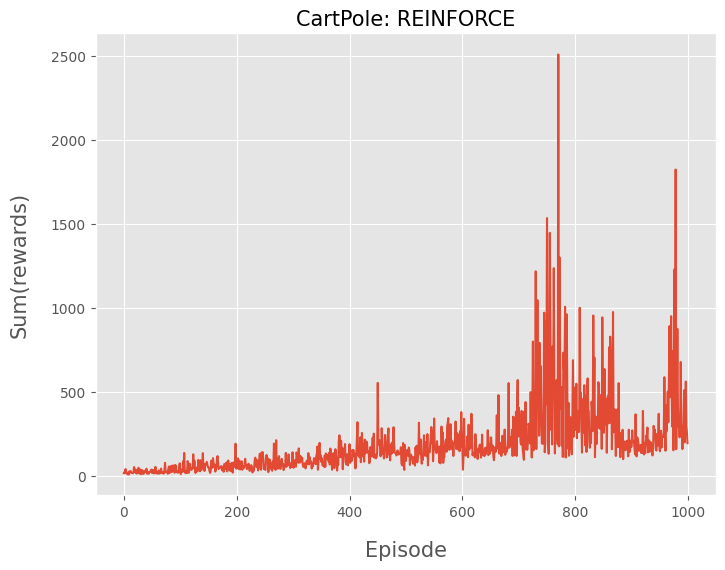

In [18]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(range(NUM_EPISODES), score_per_episode)
ax.set_xlabel('Episode', fontsize=15, labelpad=15)
ax.set_ylabel('Sum(rewards)', fontsize=15, labelpad=15)
ax.set_title('CartPole: REINFORCE', fontsize=15)

### Random policy 

In [22]:
score_per_episode = []
for _ in range(NUM_EPISODES):
    done = False 
    state = env.reset()[0]
    score = 0.
    for _ in range(MAX_STEPS):
        action = env.action_space.sample()
        new_state, reward, done, _, info = env.step(action)
        score += reward
        if done:
            break 
        state = new_state # not used
    score_per_episode.append(score)

Text(0.5, 1.0, 'CartPole: random policy')

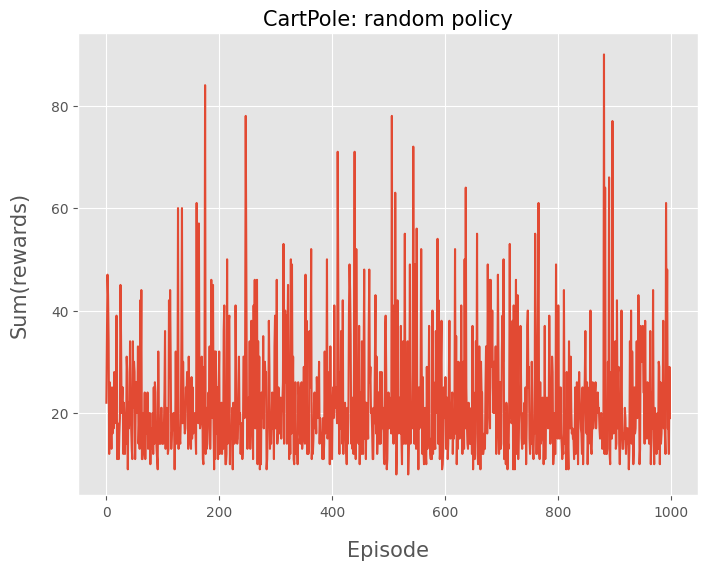

In [23]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(range(NUM_EPISODES), score_per_episode)
ax.set_xlabel('Episode', fontsize=15, labelpad=15)
ax.set_ylabel('Sum(rewards)', fontsize=15, labelpad=15)
ax.set_title('CartPole: random policy', fontsize=15)